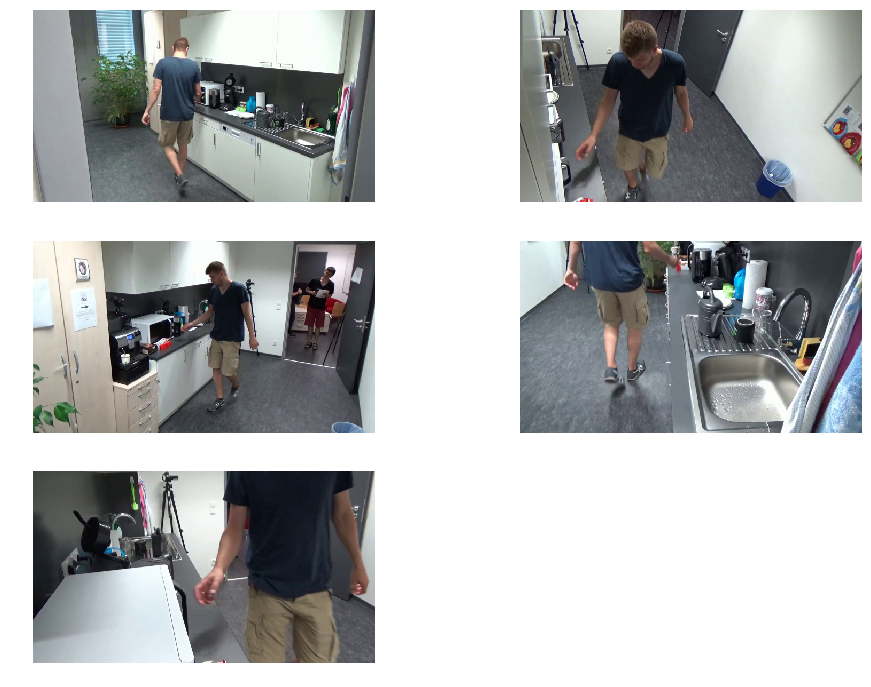

In [2]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import umpm
from mvpose.algorithm.settings import get_settings, get_tracking_settings

from mvpose.geometry.camera import ProjectiveCamera


Calib = []


root = '/home/julian/Videos/Ohhun2/'

FRAME = 200

def get_frame(FRAME):
    
    rvec1 = np.array([0.16545158, -0.58661209, -0.06812171])
    rvec2 = np.array([-0.04250409,  2.45650291,  1.10521635])
    rvec3 = np.array([0.09840657, -2.57816745, -0.41950383])
    rvec4 = np.array([ 0.52513269, -0.0662031,  -0.00803111])
    rvec5 = np.array([-0.10026737, -3.28390404, -0.66452672])
    RVECS = [rvec1, rvec2, rvec3, rvec4, rvec5]

    tvec1 = np.array([0.44144942, 0.38051085, 0.55277737])
    tvec2 = np.array([-0.68141818, -1.59333381,  3.40779297])
    tvec3 = np.array([ 1.92349354, -0.80108797,  4.7754596])
    tvec4 = np.array([-0.89558074,  0.49120452, -0.07311327])
    tvec5 = np.array([ 0.41491288, -0.97094642,  3.12052051])
    TVECS = [tvec1, tvec2, tvec3, tvec4, tvec5]
    
    Ims = []
    for cid in range(1, 6):
        #fname = 'test1_cam%1d-011.mp4' % cid
        fname = '180801_%1d-007.mp4' % cid
        fname = join(root, fname)
        assert isfile(fname)

        cap = cv2.VideoCapture(fname)
        for f in range(FRAME):
            ret, frame = cap.read()
        
        im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, None, fx=0.5, fy=0.5)
        Ims.append(im)

        fname_c = 'cam%1d.txt' % cid
        fname_c = join(root, fname_c)
        assert isfile(fname_c)
        param_intrinsic = np.loadtxt(fname_c)
        K = param_intrinsic[:9].reshape(3,3)
        dist = param_intrinsic[9:]

        h, w, _ = Ims[0].shape
        rvec = RVECS[cid-1]
        tvec = TVECS[cid-1]
        Calib.append(ProjectiveCamera(K, rvec, tvec, dist, w, h))
    return Ims, Calib

Im, Calib = get_frame(FRAME)
    

fig = plt.figure(figsize=(16,12))
for idx, im in enumerate(Im):
    ax = fig.add_subplot(3,2,idx+1)
    ax.axis('off')
    ax.imshow(im)
    
plt.show()

In [5]:
from mvpose import pose
from mvpose.plot.limbs import draw_mscoco_human
from mvpose.algorithm import settings

frame = FRAME
heatmaps, pafs = paf_loader.load_confidence_map_and_paf('ohhun', 
                                                        Im,
                                                        frame,
                                                        dir='/tmp')

params = settings.get_settings(scale_to_mm=1000)

_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs, 
                                  settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
print("# detections", len(detections))

step 1: elapsed 1.2518374919891357
step 2: elapsed 0.008100032806396484
	not enough 3d points found: early stopping! 1

total elapsed: 1.260725736618042
# detections 0


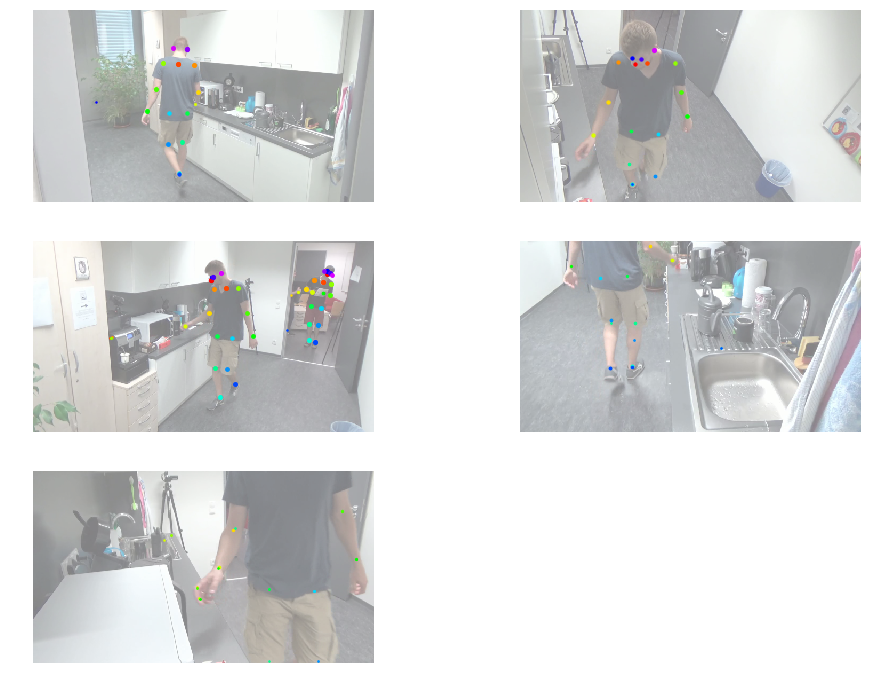

In [18]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(3, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    peaks2d = Debug.candidates2d.peaks2d[cid]
    for jid, peaks2d in enumerate(peaks2d):
        for x, y, s in peaks2d:
            ax.scatter(x, y, color=colors[jid], s=s*20)
    
plt.show()

1183.7695141791598
458.90782692535936
-545.787365956494 121.92423820811607


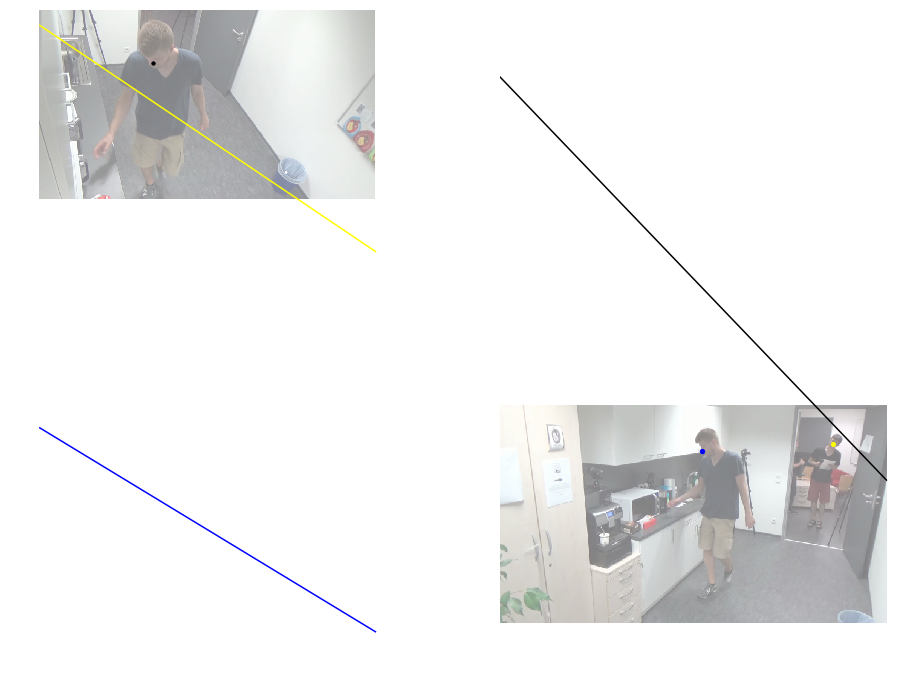

In [64]:
import mvpose.geometry.stereo as stereo

jid = 0
cam1 = 1
cam2 = 2

# ------------------------
def draw_peaks(ax, cid, colors):
    peaks2d = Debug.candidates2d.peaks2d[cid][jid]
    for i, (x, y, s) in enumerate(peaks2d):
        ax.scatter(x, y, color=colors[i], s=s*20)

# ------------------------

pts2d_1 = Debug.candidates2d.peaks2d[cam1][jid][:, 0:2]
pts2d_2 = Debug.candidates2d.peaks2d[cam2][jid][:, 0:2]

epilines_1to2 = np.squeeze(
    cv2.computeCorrespondEpilines(pts2d_1, 1, F))
if len(epilines_1to2.shape) <= 1:
    epilines_1to2 = np.expand_dims(epilines_1to2, axis=0)
    
epilines_2to1 = np.squeeze(
    cv2.computeCorrespondEpilines(pts2d_2, 2, F))
if len(epilines_2to1.shape) <= 1:
    epilines_2to1 = np.expand_dims(epilines_2to1, axis=0)
    

get_y = lambda a, b, c, x: (-a*x-c)/b

NOSE_1_COLORS = ['black']
NOSE_2_COLORS = ['blue', 'yellow']

im1 = Im[cam1]
im2 = Im[cam2]

P1 = Calib[cam1].P
P2 = Calib[cam2].P
F = stereo.get_fundamental_matrix(P1, P2)


fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(im1, alpha=0.5)
ax.axis('off')
draw_peaks(ax, cam1, NOSE_1_COLORS)

for i, (a, b, c) in enumerate(epilines_2to1):
    x1 = 0
    y1 = get_y(a, b, c, x1)
    x2 = 640
    y2 = get_y(a, b, c, x2)
    
    print(y2)
    
    ax.plot([x1, x2], [y1, y2], color=NOSE_2_COLORS[i])


ax = fig.add_subplot(1, 2, 2)
ax.imshow(im2, alpha=0.5)
ax.axis('off')
draw_peaks(ax, cam2, NOSE_2_COLORS)

for i, (a, b, c) in enumerate(epilines_1to2):
    x1 = 0
    y1 = get_y(a, b, c, x1)
    x2 = 640
    y2 = get_y(a, b, c, x2)
    print(y1, y2)
    ax.plot([x1, x2], [y1, y2], color=NOSE_1_COLORS[i])
    

plt.show()


In [ ]:
# from mvpose.algorithm.candidate_selection import project_human_to_2d
# from mvpose.plot.limbs import draw_mscoco_human

# Humans = detections

# fig = plt.figure(figsize=(16,12))

# colors = ['red', 'blue', 'green']

# for idx, cam in enumerate(Calib):
#     ax = fig.add_subplot(2,2,1+idx)
#     ax.axis('off')
#     im = Ims[idx]
#     h,w,_ = im.shape
#     ax.imshow(im, alpha=0.6)
    
#     for pid, human in enumerate(Humans):
#         draw_mscoco_human(ax, human, cam, color=colors[pid])
        
# plt.show()